In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot_tools import plot_groups, plot_input_image
%matplotlib inline
np.random.seed(104174)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Shapes Problem

Binary images containing 3 random shapes each. Introduced in [1] to investigate binding in deep networks.


In [2]:
square = np.array(
    [[1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1]])

triangle = np.array(
    [[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
     [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
     [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

shapes = [square, triangle, triangle[::-1, :].copy()]

In [3]:
def generate_shapes_image(width, height, nr_shapes=3):
    img = np.zeros((height, width))
    grp = np.zeros_like(img)
    k = 1
    
    for i in range(nr_shapes):
        shape = shapes[np.random.randint(0, len(shapes))]
        sy, sx = shape.shape
        x = np.random.randint(0, width-sx+1)
        y = np.random.randint(0, height-sy+1)
        region = (slice(y,y+sy), slice(x,x+sx))
        img[region][shape != 0] += 1
        grp[region][shape != 0] = k        
        k += 1
        
    grp[img > 1] = 0
    img = img != 0
    return img, grp

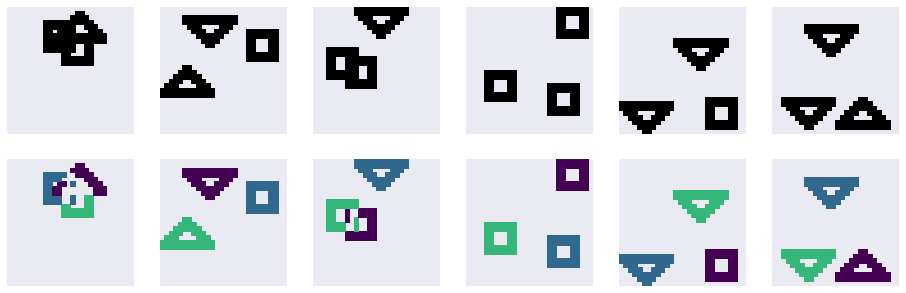

In [4]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(16, 5))
for ax in axes.T:
    img, grp = generate_shapes_image(28, 28, 3)
    plot_input_image(img, ax[0])
    plot_groups(grp, ax[1])

# Save as HDF5 Dataset

In [5]:
import h5py
import os
import os.path

data_dir = os.environ.get('BRAINSTORM_DATA_DIR', '.')

In [6]:
np.random.seed(265076)
nr_train_examples = 60000
nr_test_examples = 10000
nr_single_examples = 10000
width = 28
height = 28
nr_shapes = 3

data = np.zeros((1, nr_train_examples, height, width, 1), dtype=np.float32)
grps = np.zeros_like(data)
for i in range(nr_train_examples):
    data[0, i, :, :, 0], grps[0, i, :, :, 0] = generate_shapes_image(width, height, nr_shapes)
    
data_test = np.zeros((1, nr_test_examples, height, width, 1), dtype=np.float32)
grps_test = np.zeros_like(data_test)
for i in range(nr_test_examples):
    data_test[0, i, :, :, 0], grps_test[0, i, :, :, 0] = generate_shapes_image(width, height, nr_shapes)

data_single = np.zeros((1, nr_single_examples, height, width, 1), dtype=np.float32)
grps_single = np.zeros_like(data_single)
for i in range(nr_single_examples):
    data_single[0, i, :, :, 0], grps_single[0, i, :, :, 0] = generate_shapes_image(width, height, 1)

In [7]:
import h5py

with h5py.File(os.path.join(data_dir, 'shapes.h5'), 'w') as f:
    single = f.create_group('train_single')
    single.create_dataset('default', data=data_single, compression='gzip', chunks=(1, 100, height, width, 1))
    single.create_dataset('groups', data=grps_single, compression='gzip', chunks=(1, 100, height, width, 1))
    
    train = f.create_group('train_multi')
    train.create_dataset('default', data=data, compression='gzip', chunks=(1, 100, height, width, 1))
    train.create_dataset('groups', data=grps, compression='gzip', chunks=(1, 100, height, width, 1))
    
    test = f.create_group('test')
    test.create_dataset('default', data=data_test, compression='gzip', chunks=(1, 100, height, width, 1))
    test.create_dataset('groups', data=grps_test, compression='gzip', chunks=(1, 100, height, width, 1))

# References
[1] David P. Reichert and Thomas Serre, [Neuronal Synchrony in Complex-Valued Deep Networks](http://arxiv.org/abs/1312.6115), ICLR 2014

